# 0. Clone Repo & Install Dependencies

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

# Change the current working directory
os.chdir('/content/drive/MyDrive/git/tensortrade-train')

# Print the current working directory
print("New working directory: {0}".format(os.getcwd()))

## 0.1 Clone/update repo

In [ ]:
if not os.path.isdir(os.getcwd()+'/.git'):
  !git init && git remote add origin https://github.com/dennislwy/tensortrade-train.git && git pull origin master
else:  # repo already exists, update it
  !git pull origin master

## 0.2 Install dependencies
Check GPU availability

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
gpu_available = not (gpu_info.find('failed')>=0 or gpu_info.find('not recognized')>=0)
if gpu_available:
  print('GPU available')
  print(gpu_info)
else:
  print('GPU NOT available')
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')

GPU NOT available
Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


Install requirements

In [13]:
# ipywidgets is required to run Plotly in Jupyter Notebook.
# Uncomment and run the following line to install it if required.

#!pip install ipywidgets

In [2]:
if gpu_available:
  print("Installing GPU requirement packages")
  !pip install -r requirements.txt
else:
  print("Installing non-GPU requirement packages")
  !pip install -r requirements.no-gpu.txt

Installing non-GPU requirement packages


## Imports

In [3]:
import ta

import pandas as pd
import numpy as np
from tensortrade.feed.core import Stream, DataFeed, NameSpace
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
#from tensortrade.oms.instruments import USD, BTC
from tensortrade.oms.wallets import Wallet, Portfolio

%matplotlib inline

## Load Instruments

In [4]:
from tensortrade.oms.instruments import Instrument

USD = Instrument("USD", 2, "U.S. Dollar")
TTC = Instrument("TTC", 8, "TensorTrade Coin")

## Data Preparation
### Load data

In [5]:
training_data_path = 'data/sine-fixed-15m-btc-usdt.csv'
testing_data_path = 'data/sine-fixed-15m-btc-usdt.csv'

In [6]:
df = pd.read_csv(training_data_path)
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,open,high,low,close,volume
0,2021-03-01 00:00:00,35000.000000,35004.52,34862.89,35000.000000,360.829789
1,2021-03-01 00:15:00,35000.000000,35321.81,34924.01,35037.546059,444.194401
2,2021-03-01 00:30:00,35037.546059,35245.11,34712.08,35075.087797,1681.385710
3,2021-03-01 00:45:00,35075.087797,35133.24,34797.06,35112.620894,1658.398344
4,2021-03-01 01:00:00,35112.620894,35367.45,34897.52,35150.141031,525.009075


### Create the dataset features

In [7]:
from ta.trend import *

dataset = pd.DataFrame()
dataset['macd_diff'] = macd_diff(df['close'], fillna=True)
dataset2 = pd.DataFrame()
dataset2['ema25'] = ema_indicator(df['close'], 25, fillna = True)
dataset2['ema50'] = ema_indicator(df['close'], 50, fillna = True)
dataset['emaNormDiff'] = 1-dataset2['ema50']/dataset2['ema25']

In [8]:
dataset

,macd_diff,emaNormDiff
0,0.000000,0.000000
1,2.396102,0.000040
2,6.162689,0.000117
3,10.576222,0.000224
4,15.138951,0.000359
...,...,...
5852,3.283575,0.011806
5853,3.169256,0.011853
5854,3.054571,0.011898
5855,2.939535,0.011942


In [69]:
# import ta
# dataset = ta.add_all_ta_features(df, 'open', 'high', 'low', 'close', 'volume', fillna=True)
# dataset.head(3)

c:\git\dennislee\tensortrade-bot\venv\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
c:\git\dennislee\tensortrade-bot\venv\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


,date,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
0,2021-03-01 00:00:00,35000.000000,35004.52,34862.89,35000.000000,360.829789,337.798642,360.829789,0.936172,0.000000,...,-3.191414,0.0,35000.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2021-03-01 00:15:00,35000.000000,35321.81,34924.01,35037.546059,444.194401,147.159202,805.024190,0.182801,16677.749212,...,-61.941938,0.0,35354.124454,0.0,1.812011,0.362402,1.449608,0.107274,0.107217,0.107274
2,2021-03-01 00:30:00,35037.546059,35245.11,34712.08,35075.087797,1681.385710,755.911469,2486.409901,0.304017,23312.662486,...,-40.464173,0.0,34158.712719,0.0,23.791113,5.048144,18.742968,0.107147,0.107090,0.214537


### Create Chart Price History Data
Note: It is recommended to create the chart data *after* creating and cleaning the dataset to ensure one-to-one mapping between the historical prices data and the dataset.

In [9]:
price_history = df
display(price_history.head(3))

,date,open,high,low,close,volume
0,2021-03-01 00:00:00,35000.000000,35004.52,34862.89,35000.000000,360.829789
1,2021-03-01 00:15:00,35000.000000,35321.81,34924.01,35037.546059,444.194401
2,2021-03-01 00:30:00,35037.546059,35245.11,34712.08,35075.087797,1681.385710


In [96]:
# price_history = dataset[['date', 'open', 'high', 'low', 'close', 'volume']] 
# display(price_history.head(3))

# dataset.drop(columns=['date', 'open', 'high', 'low', 'close', 'volume'], inplace=True)

KeyError: "None of [Index(['date', 'open', 'high', 'low', 'close', 'volume'], dtype='object')] are in the [columns]"

<AxesSubplot:>

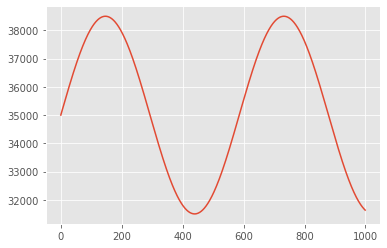

In [11]:
price_history['close'].head(1000).plot()

In [12]:
dataset

,macd_diff,emaNormDiff
0,0.000000,0.000000
1,2.396102,0.000040
2,6.162689,0.000117
3,10.576222,0.000224
4,15.138951,0.000359
...,...,...
5852,3.283575,0.011806
5853,3.169256,0.011853
5854,3.054571,0.011898
5855,2.939535,0.011942


## Display & Inspect Price History

In [13]:
!pip install mplfinance

In [15]:
import mplfinance as mpf
cd = df.copy()  

# total data length in dataset
data_length = len(cd)
print(f"Total data length: {data_length}")

Total data length: 5857


# Calculate Indicators

In [18]:
cd['emaNormDiff'] = dataset['emaNormDiff']
cd['macd_diff'] = dataset['macd_diff']
cd

,date,open,high,low,close,volume,emaNormDiff,macd_diff
0,2021-03-01 00:00:00,35000.000000,35004.52,34862.89,35000.000000,360.829789,0.000000,0.000000
1,2021-03-01 00:15:00,35000.000000,35321.81,34924.01,35037.546059,444.194401,0.000040,2.396102
2,2021-03-01 00:30:00,35037.546059,35245.11,34712.08,35075.087797,1681.385710,0.000117,6.162689
3,2021-03-01 00:45:00,35075.087797,35133.24,34797.06,35112.620894,1658.398344,0.000224,10.576222
4,2021-03-01 01:00:00,35112.620894,35367.45,34897.52,35150.141031,525.009075,0.000359,15.138951
...,...,...,...,...,...,...,...,...
5852,2021-04-30 23:00:00,34774.874848,35093.46,34611.74,34812.356111,1473.074458,0.011806,3.283575
5853,2021-04-30 23:15:00,34812.356111,35040.11,34746.02,34849.858969,404.187560,0.011853,3.169256
5854,2021-04-30 23:30:00,34849.858969,34958.71,34611.91,34887.379106,1427.198419,0.011898,3.054571
5855,2021-04-30 23:45:00,34887.379106,35055.25,34729.67,34924.912203,1045.565271,0.011942,2.939535


In [19]:
cd.set_index('date', inplace=True)
cd

,open,high,low,close,volume,emaNormDiff,macd_diff
date,,,,,,,
2021-03-01 00:00:00,35000.000000,35004.52,34862.89,35000.000000,360.829789,0.000000,0.000000
2021-03-01 00:15:00,35000.000000,35321.81,34924.01,35037.546059,444.194401,0.000040,2.396102
2021-03-01 00:30:00,35037.546059,35245.11,34712.08,35075.087797,1681.385710,0.000117,6.162689
2021-03-01 00:45:00,35075.087797,35133.24,34797.06,35112.620894,1658.398344,0.000224,10.576222
2021-03-01 01:00:00,35112.620894,35367.45,34897.52,35150.141031,525.009075,0.000359,15.138951
...,...,...,...,...,...,...,...
2021-04-30 23:00:00,34774.874848,35093.46,34611.74,34812.356111,1473.074458,0.011806,3.283575
2021-04-30 23:15:00,34812.356111,35040.11,34746.02,34849.858969,404.187560,0.011853,3.169256
2021-04-30 23:30:00,34849.858969,34958.71,34611.91,34887.379106,1427.198419,0.011898,3.054571


# Plot Price History Chart

c:\git\dennislee\tensortrade-bot\venv\lib\site-packages\mplfinance\_arg_validators.py:45: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  category=UserWarning)


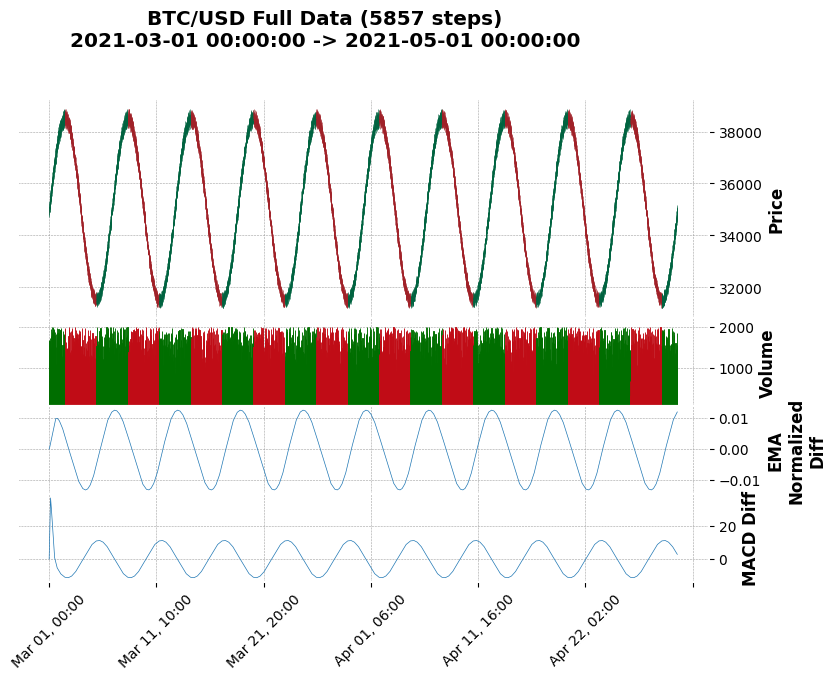

In [20]:
#overlays = df[['ema25', 'ema50']]
apds = [ 
         #mpf.make_addplot(overlays, width=0.5), 
         mpf.make_addplot(cd['emaNormDiff'], panel=2, width=0.5, ylabel='EMA\nNormalized\nDiff'),
         mpf.make_addplot(cd['macd_diff'], panel=3, width=0.5, ylabel='MACD Diff'),
       ]
mpf.plot(cd, type='candle', 
         style='charles', volume=True,
         title='BTC/USD Full Data (%d steps)\n%s -> %s' % (data_length, cd.index[0], cd.index[data_length-1]), 
         addplot=apds, figscale=1.2)

### Create Streams

In [21]:
# Setup stream based on 'Close'
close = Stream.source(price_history['close'].tolist(), dtype="float").rename("USD-TTC")

In [68]:
# # Setup stream based on sine wave
# x = np.arange(0, 2*np.pi, 2*np.pi / 1001)
# y = 3000*np.sin(2.25*x) + 35000

# x = np.arange(0, 2*np.pi, 2*np.pi / 1000)
# close = Stream.source(y, dtype="float").rename("USD-TTC")
# pd.DataFrame(y).plot()

### Create Data Feeds

In [22]:
# feed with all indicators
# with NameSpace("bitfinex"):
#     streams = [Stream.source(dataset[c].tolist(), dtype="float").rename(c) for c in dataset.columns]

# feed = DataFeed(streams)

In [23]:
# feed with custom indicators
# feed = DataFeed([
#     close,
#     close.rolling(window=10).mean().rename("fast"),
#     close.rolling(window=50).mean().rename("medium"),
#     close.rolling(window=100).mean().rename("slow"),
#     close.log().diff().fillna(0).rename("lr")
# ])

In [26]:
feed = DataFeed([
    Stream.source(dataset['emaNormDiff'].tolist(), dtype="float").rename("ema_norm_diff")
])

In [25]:
feed.next()

{'ema_norm_diff': 0.0}

### Trading Environment Renderers
A renderer is a channel for the trading environment to output its current state. One or more renderers can be attached to the environment at the same time. For example, you can let the environment draw a chart and log to a file at the same time.

Notice that while all renderers can technically be used together, you need to select the best combination to avoid undesired results. For example, PlotlyTradingChart can work well with FileLogger but may not display well with ScreenLogger.

Renderer can be set by name (string) or class, single or list. Available renderers are:
* `'screenlog'` or `ScreenLogger`: Shows results on the screen.
* `'filelog'` or `FileLogger`: Logs results to a file.
* `'plotly'` or `PlotlyTradingChart`: A trading chart based on Plotly.

#### Examples:

* renderers = 'screenlog' (default)
* renderers = ['screenlog', 'filelog']
* renderers = ScreenLogger()
* renderers = ['screenlog', `FileLogger()`]
* renderers = [`FileLogger(filename='example.log')`]

Renderers can also be created and configured first then attached to the environment as seen in a following example.

### Environment with Multiple Renderers
Create PlotlyTradingChart and FileLogger renderers. Configuring renderers is optional as they can be used with their default settings.

With the plotly renderer you must provide an parameter called `renderer_feed`. This is a `DataFeed` instance that provides all the information that is required by a renderer to function.

In [133]:
from tensortrade.env.default.renderers import PlotlyTradingChart, FileLogger

chart_renderer = PlotlyTradingChart(
    display=True,  # show the chart on screen (default)
    height=800,  # affects both displayed and saved file height. None for 100% height.
    save_format="html",  # save the chart to an HTML file
    auto_open_html=True,  # open the saved HTML chart in a new browser tab
)

file_logger = FileLogger(
    filename="example.log",  # omit or None for automatic file name
    path="training_logs"  # create a new directory if doesn't exist, None for no directory
)

### Create Exchange & Portfolio

In [27]:
bitfinex = Exchange("bitfinex", service=execute_order)(
    close
)

cash = Wallet(bitfinex, 1000 * USD)
asset = Wallet(bitfinex, 0 * TTC)

portfolio = Portfolio(USD, [
    cash,
    asset
])

### Reward & Action Scheme

In [29]:
from BSH import BSH
from PBR import PBR

reward_scheme = PBR(price=close)
#reward_scheme="risk-adjusted"
    
action_scheme = BSH(
    cash=cash,
    asset=asset
).attach(reward_scheme)
#action_scheme="managed-risk"

### Renderer Feed

In [ ]:
# renderer_feed = DataFeed([
#     Stream.source(price_history[c].tolist(), dtype="float").rename(c) for c in price_history]
# )

In [30]:
renderer_feed = DataFeed([
    Stream.source(price_history['close'].tolist(), dtype="float").rename("price"),
    Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
])

In [75]:
# renderer_feed = DataFeed([
#     Stream.source(y, dtype="float").rename("price"),
#     Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
# ])

In [31]:
# renderer_feed = DataFeed([
#     price,
#     Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
# ])

In [58]:
# renderer_feed = DataFeed([
#     close
# ])

### Setup Environment

In [31]:
import tensortrade.env.default as default
from PositionChangeChart import PositionChangeChart

window_size = 25

env = default.create(
    portfolio=portfolio,
    action_scheme=action_scheme,
    reward_scheme=reward_scheme,
    feed=feed,
    window_size=window_size,
    renderer_feed=renderer_feed,
    renderer=PositionChangeChart()
)

# env = default.create(
#     portfolio=portfolio,
#     action_scheme=action_scheme,
#     reward_scheme=reward_scheme,
#     feed=feed,
#     window_size=window_size,
#     renderer_feed=renderer_feed,
#     renderers=[
#         chart_renderer, 
#         file_logger
#     ]
# )

## Setup and Train DQN Agent
The green and red arrows shown on the chart represent buy and sell trades respectively. The head of each arrow falls at the trade execution price.

====      AGENT ID: c3c3af7d-817a-4558-bb9c-9821629071e0      ====


c:\git\dennislee\tensortrade-bot\venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


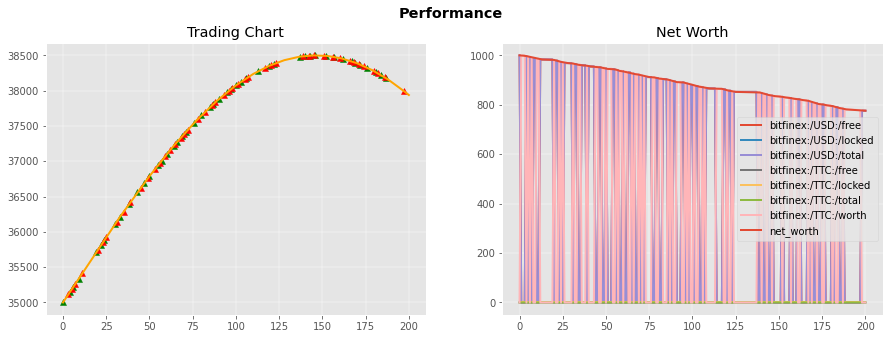

c:\git\dennislee\tensortrade-bot\venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


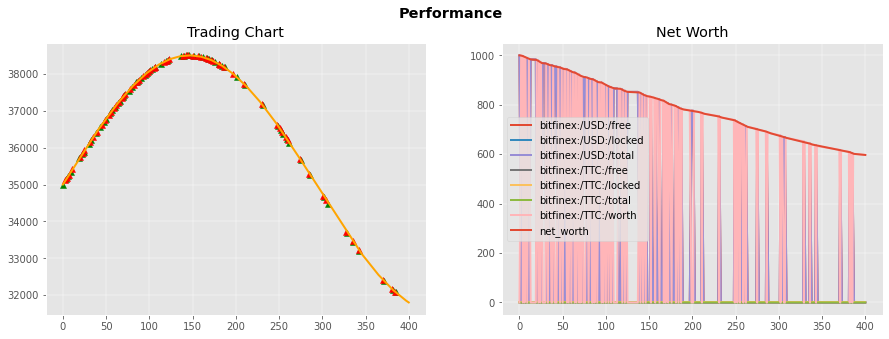

c:\git\dennislee\tensortrade-bot\venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


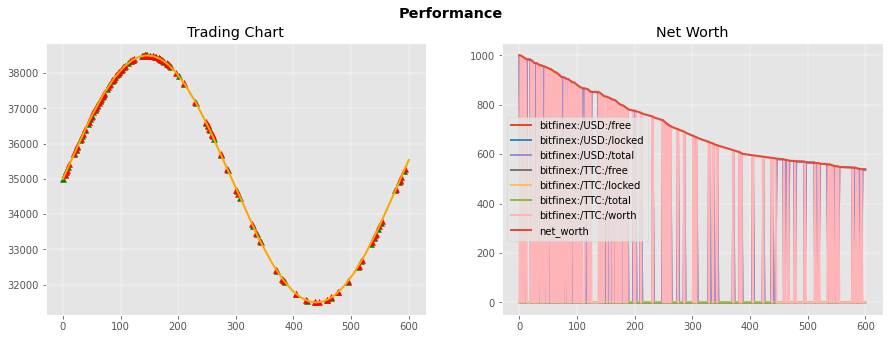

c:\git\dennislee\tensortrade-bot\venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


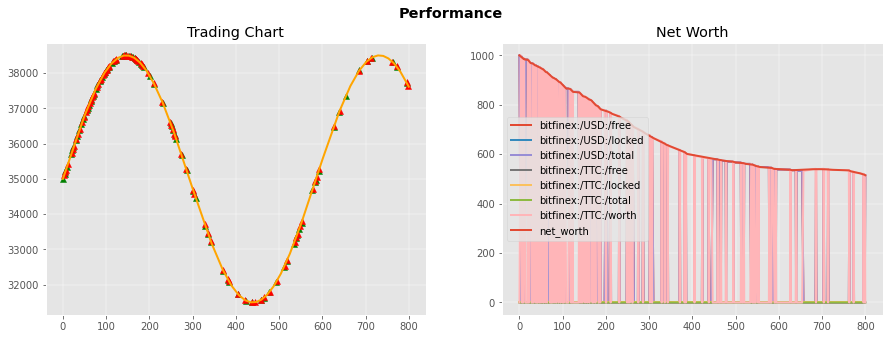

c:\git\dennislee\tensortrade-bot\venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


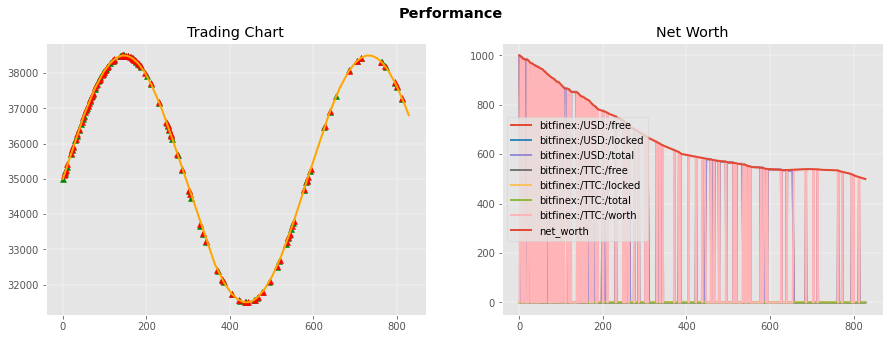

c:\git\dennislee\tensortrade-bot\venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


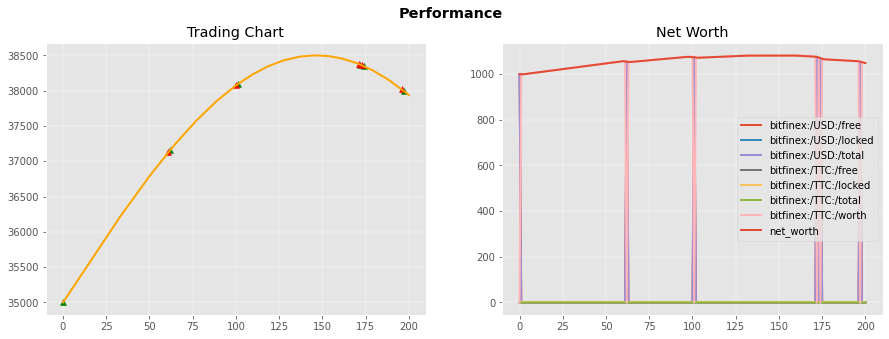

c:\git\dennislee\tensortrade-bot\venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


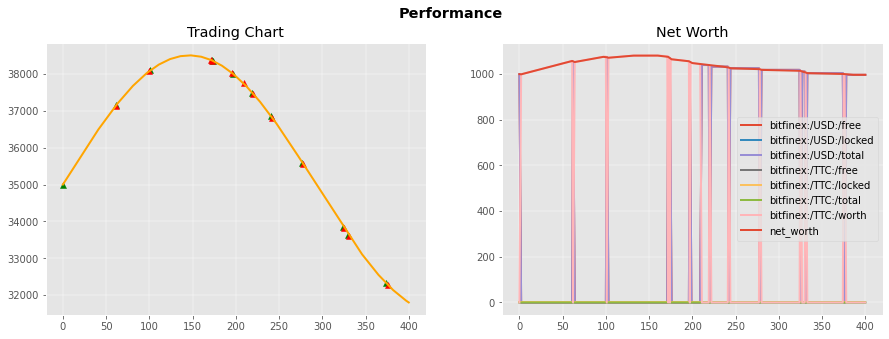

c:\git\dennislee\tensortrade-bot\venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


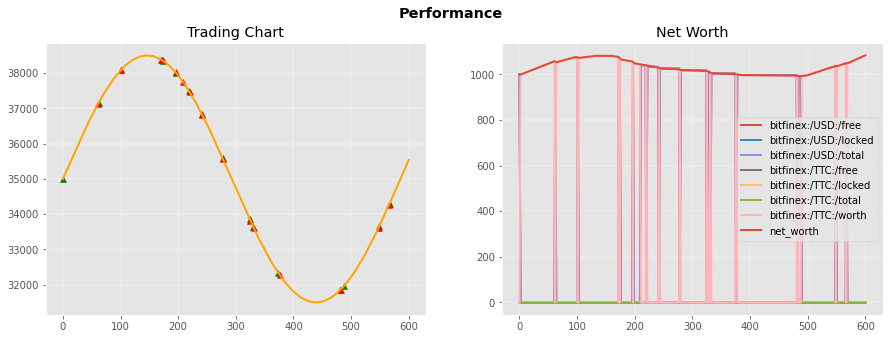

c:\git\dennislee\tensortrade-bot\venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


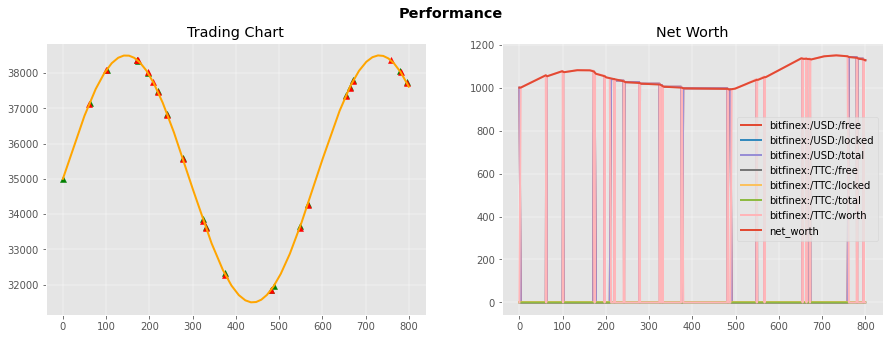

c:\git\dennislee\tensortrade-bot\venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


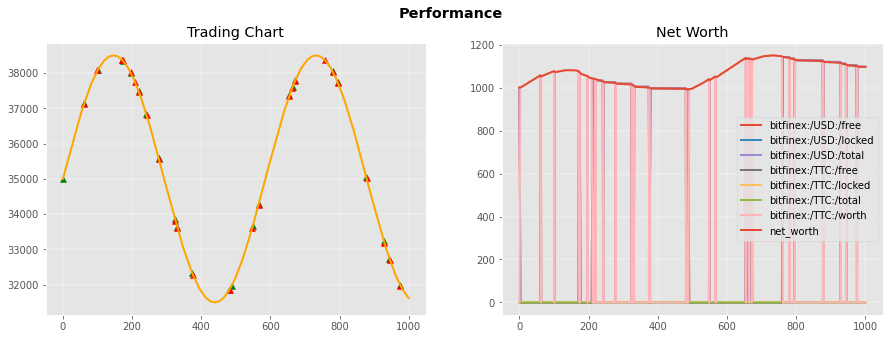

9.609417422252864

In [138]:
from tensortrade.agents import DQNAgent

episodes = 10
steps = 1000
render_interval = 500

agent = DQNAgent(env)

# Set render_interval to None to render at episode ends only
agent.train(n_episodes=episodes, n_steps=steps, render_interval=render_interval)

## Direct Performance and Net Worth Plotting
Alternatively, the final performance and net worth can be displayed using pandas via Matplotlib.

<AxesSubplot:>

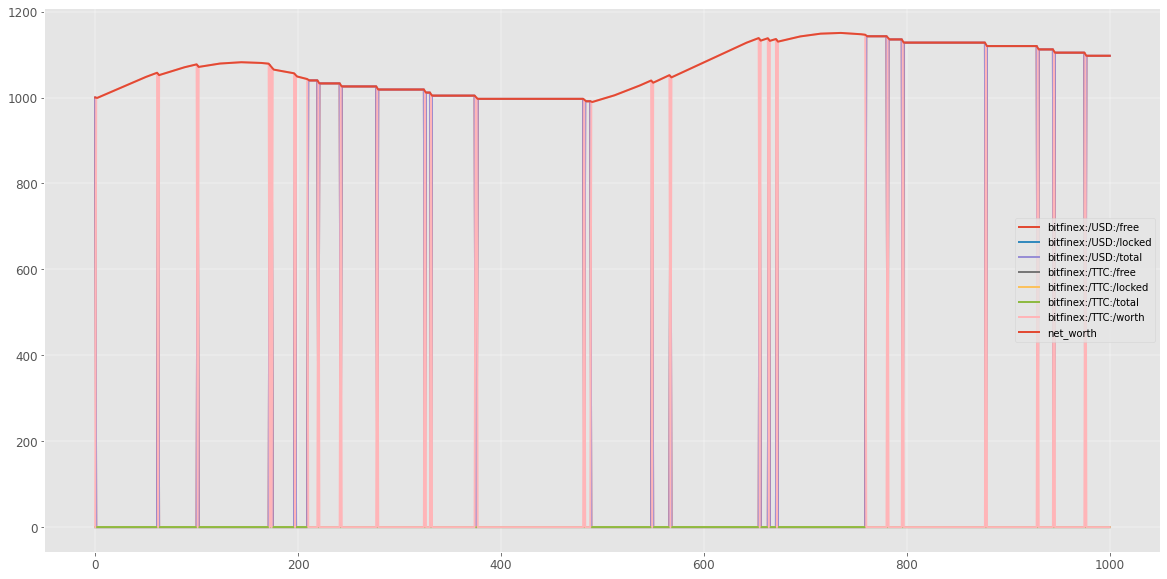

In [139]:
%matplotlib inline

performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
performance.drop(['bitfinex:/USD-TTC'], axis=1, inplace=True)
# performance.plot()
performance.plot(figsize=[20,10], fontsize=12)

<AxesSubplot:>

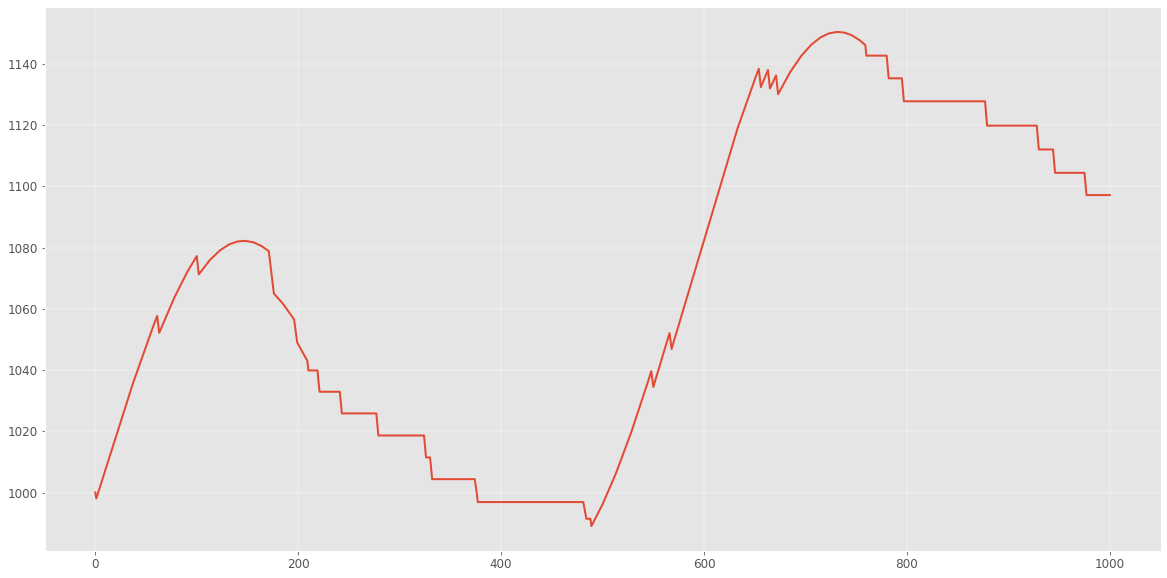

In [140]:
#portfolio.performance.net_worth.plot()
performance.net_worth.plot(figsize=[20,10], fontsize=12)

In [141]:
env.action_scheme.portfolio.performance

OrderedDict([(0,
              {'bitfinex:/USD-TTC': 35000.0,
               'bitfinex:/USD:/free': 1000.0,
               'bitfinex:/USD:/locked': 0.0,
               'bitfinex:/USD:/total': 1000.0,
               'bitfinex:/TTC:/free': 0.0,
               'bitfinex:/TTC:/locked': 0.0,
               'bitfinex:/TTC:/total': 0.0,
               'bitfinex:/TTC:/worth': 0.0,
               'net_worth': 1000.0,
               'base_symbol': 'USD'}),
             (1,
              {'bitfinex:/USD-TTC': 35037.546059037326,
               'bitfinex:/USD:/free': 0.0,
               'bitfinex:/USD:/locked': 0.0,
               'bitfinex:/USD:/total': 0.0,
               'bitfinex:/TTC:/free': 0.02848571,
               'bitfinex:/TTC:/locked': 0.0,
               'bitfinex:/TTC:/total': 0.02848571,
               'bitfinex:/TTC:/worth': 998.0693761493802,
               'net_worth': 998.0693761493802,
               'base_symbol': 'USD'}),
             (2,
              {'bitfinex:/USD-TTC': 3

In [142]:
performance.net_worth[len(performance.net_worth)-1]

1097.16